## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.6.0+cu126'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Tue Jun  3 12:38:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.02                 Driver Version: 576.02         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   28C    P0             12W /   60W |     466MiB /   4096MiB |     31%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data 

Our dataset is a subset of the Food101 dataset.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("/data")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory already exists.. skipping download")
else:
    print(f"{image_path} does not exist, creating one..")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, suhsi data...")
    f.write(request.content)
    
# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak and sushi data...")
    zip_ref.extractall(image_path)

\data\pizza_steak_sushi directory already exists.. skipping download
Unzipping pizza, steak and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, file_names in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(file_names)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '\data\pizza_steak_sushi'.
There are 3 directories and 0 images in '\data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in '\data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in '\data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in '\data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in '\data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in '\data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in '\data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in '\data\pizza_steak_sushi\train\sushi'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('/data/pizza_steak_sushi/train'),
 WindowsPath('/data/pizza_steak_sushi/test'))

### 2.1 Visualizing and image

Let's write some code to:
1. Get all of the image paths 
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem` 
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

In [8]:
image_path

WindowsPath('/data/pizza_steak_sushi')

Random image path: \data\pizza_steak_sushi\test\sushi\499605.jpg
Image class: sushi
Image height: 512
Image width: 512


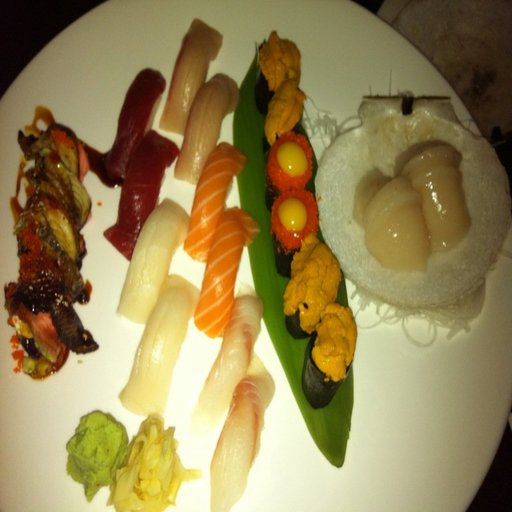

In [9]:
import random 
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata 
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


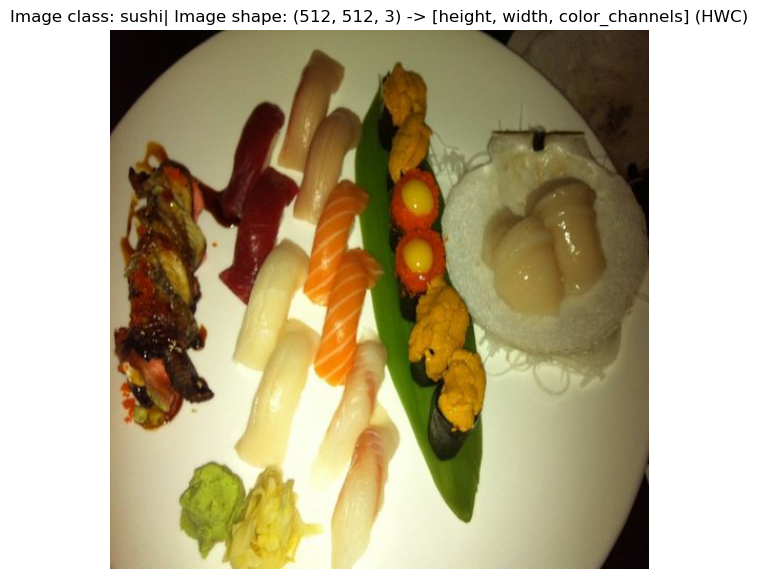

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class}| Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

## 3. Transforming data 

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.



In [11]:
import torch 
from torch.utils.data import dataloader
from torchvision import transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation - https://pytorch.org/vision/stable/transforms.html 


In [13]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our image to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [15]:
data_transform(img)

tensor([[[0.0471, 0.0471, 0.0431,  ..., 0.2157, 0.2039, 0.1882],
         [0.0471, 0.0471, 0.0431,  ..., 0.2118, 0.2078, 0.2039],
         [0.0471, 0.0471, 0.0431,  ..., 0.2157, 0.2000, 0.2000],
         ...,
         [0.6588, 0.6941, 0.7137,  ..., 0.0510, 0.0471, 0.0471],
         [0.6510, 0.6824, 0.7098,  ..., 0.0471, 0.0471, 0.0392],
         [0.6275, 0.6667, 0.7020,  ..., 0.0471, 0.0431, 0.0392]],

        [[0.0118, 0.0118, 0.0118,  ..., 0.1529, 0.1412, 0.1216],
         [0.0118, 0.0118, 0.0118,  ..., 0.1569, 0.1451, 0.1373],
         [0.0118, 0.0118, 0.0078,  ..., 0.1490, 0.1373, 0.1333],
         ...,
         [0.5725, 0.6157, 0.6510,  ..., 0.0157, 0.0157, 0.0118],
         [0.5569, 0.6039, 0.6431,  ..., 0.0118, 0.0118, 0.0157],
         [0.5373, 0.5961, 0.6353,  ..., 0.0118, 0.0078, 0.0118]],

        [[0.0235, 0.0235, 0.0157,  ..., 0.1020, 0.0941, 0.0863],
         [0.0235, 0.0235, 0.0157,  ..., 0.1020, 0.0980, 0.0980],
         [0.0235, 0.0235, 0.0157,  ..., 0.0980, 0.0863, 0.

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])